In [1]:
# Written by: Daniel Seungwook Min, Doyle Group 
# For questions, please contact:
# Daniel: mindaniel@chem.ucla.edu
# Prof. Abby Doyle: agdoyle@chem.ucla.edu

In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read-only publicly accessible aws s3 bucket
s3 = 's3://reductionprediction/'

# Import training data
unprocessed_train = pd.read_csv(s3+"datasets/unprocessed_train_set.csv", index_col = 0)
processed_train = pd.read_csv(s3+"datasets/processed_train_set.csv", index_col = 0)
condition_space = pd.read_csv(s3+"datasets/condition_space.csv", index_col = 0)

# Define input and label
X = processed_train.drop(['z%'], axis = 1)
y = processed_train['z%']

# Convert label from z% to ∆∆G‡
T = unprocessed_train['temperature']
y_ddg = -1.987*(T+273.15)*np.log(y/(1-y))

# Structural data
is_PAr3_df = pd.read_csv(s3+"datasets/is_PAr3_all_ligands.csv", index_col = 0).dropna()
is_PAr3_train = condition_space['ligand_ID'].map(lambda x: int(is_PAr3_df['PAr3'][x]))
is_PAr3_train = is_PAr3_train.rename("PAr3")

Base Model


In [4]:
# Forward greedy feature selection
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut
from sklearn.feature_selection import SequentialFeatureSelector

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Optional switch to run the following code. Typically this code is expensive
toRun = False


if toRun:
    lolo = LeaveOneGroupOut() # cross validation split

    # Find best fit using same parameters as main model
    indices = list(lolo.split(X, y_ddg, groups = condition_space['ligand_ID']))
    kernel = Matern(length_scale = 1.5, nu = 2.5)
    regr = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
                                    n_restarts_optimizer = 5, normalize_y = True)
    sfs = SequentialFeatureSelector(regr, cv = indices, n_features_to_select = 'auto', 
                                    scoring = 'neg_mean_absolute_error', tol = 0.02)

    sfs.fit(X, y_ddg)
    extracted_features = X.columns[sfs.get_support()]
    print(extracted_features)

In [5]:
# Define subset of features to use. 
# Extracted from previous cell
feats = ['reductant_n_carbons', 'reductant_n_beta_H', 'reductant_metal',
       'ligand_nmrtens_szz_P_boltz', 'ligand_efg_amp_P_boltz',
       'ligand_efgtens_xx_P_boltz', 'ligand_nbo_lp_P_percent_s_boltz',
       'ligand_nbo_lp_P_occ_boltz', 'ligand_nbo_bds_e_avg_boltz',
       'ligand_nbo_bd_occ_avg_boltz', 'ligand_nbo_bds_occ_avg_boltz',
       'ligand_E_solv_total_boltz', 'ligand_pyr_P_boltz', 'ligand_pyr_P_delta',
       'ligand_vbur_far_vbur_boltz', 'ligand_vbur_far_vbur_min',
       'ligand_sterimol_B1_boltz', 'ligand_sterimol_B1_min',
       'ligand_sterimol_B5_delta', 'ligand_sterimol_burB5_min']

# Uncomment this for more modular flow. Otherwise skip previous cell (expensive)
# feats = extracted_features

X = X[feats]

In [6]:
# Base Model
from sklearn.model_selection import cross_validate, cross_val_predict

kernel = Matern(length_scale = 1.5, nu = 2.5)
base_model = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
                                n_restarts_optimizer = 25, normalize_y = True)
k_folds = LeaveOneGroupOut()
indices = k_folds.split(X, y_ddg, groups = condition_space['ligand_ID'])
scores = cross_validate(base_model, X, y_ddg, cv = indices, 
                        scoring = 'neg_mean_absolute_error', 
                        return_train_score = True)
                

print("Predicting Z% for base model...")
print("Test z% MAE mean", round(-scores['test_score'].mean(), 2), "cal/mol")
print("Test z% MAE std",  round(scores['test_score'].std(), 2), "cal/mol")

print("Train z% MAE mean", round(-scores['train_score'].mean(),2), "cal/mol")
print("Train z% MAE std",  round(scores['train_score'].std(), 2), "cal/mol")

print("Number of CV Scores (ligands) used in Average: ", len(scores['test_score']))
print("Features used: ", feats)
print()


Predicting Z% for base model...
Test z% MAE mean 238.44 cal/mol
Test z% MAE std 190.31 cal/mol
Train z% MAE mean 154.65 cal/mol
Train z% MAE std 1.28 cal/mol
Number of CV Scores (ligands) used in Average:  72
Features used:  ['reductant_n_carbons', 'reductant_n_beta_H', 'reductant_metal', 'ligand_nmrtens_szz_P_boltz', 'ligand_efg_amp_P_boltz', 'ligand_efgtens_xx_P_boltz', 'ligand_nbo_lp_P_percent_s_boltz', 'ligand_nbo_lp_P_occ_boltz', 'ligand_nbo_bds_e_avg_boltz', 'ligand_nbo_bd_occ_avg_boltz', 'ligand_nbo_bds_occ_avg_boltz', 'ligand_E_solv_total_boltz', 'ligand_pyr_P_boltz', 'ligand_pyr_P_delta', 'ligand_vbur_far_vbur_boltz', 'ligand_vbur_far_vbur_min', 'ligand_sterimol_B1_boltz', 'ligand_sterimol_B1_min', 'ligand_sterimol_B5_delta', 'ligand_sterimol_burB5_min']



In [7]:
# Cross-validated estimates for each input data point using LOGO CV
indices = k_folds.split(X, y_ddg, groups = condition_space['ligand_ID'])

base_preds = cross_val_predict(base_model, X, y_ddg, cv = indices)
base_preds

array([-9.69354893e+01, -4.55915538e+02, -4.35462725e+02, -9.69354893e+01,
       -4.55915538e+02, -4.35462725e+02,  5.72914007e+02,  1.09748811e+03,
        6.01348371e+02,  5.72914007e+02,  1.09748811e+03,  6.01348371e+02,
        1.38871261e+02, -3.04799227e+01, -1.68832071e+02,  1.38871261e+02,
       -3.04799227e+01, -1.68832071e+02, -4.55915538e+02, -4.55915538e+02,
       -4.55915538e+02, -4.55915538e+02, -6.68531641e+02, -6.68531641e+02,
       -6.68531641e+02, -6.68531641e+02, -4.94676938e+02, -4.94676938e+02,
       -4.94676938e+02, -4.94676938e+02, -6.41056468e+02, -6.41056468e+02,
       -6.41056468e+02, -6.41056468e+02,  1.09748811e+03,  1.09748811e+03,
        1.09748811e+03,  7.99009401e+02,  7.99009401e+02,  7.99009401e+02,
        7.99009401e+02,  1.14530963e+03,  1.14530963e+03,  1.14530963e+03,
        1.03781447e+03,  1.03781447e+03,  1.03781447e+03,  1.03781447e+03,
       -3.58424522e+02, -3.58424522e+02, -3.58424522e+02, -3.58424522e+02,
       -3.66096969e+02, -

In [8]:
y_ddg_base_error = y_ddg - base_preds
y_ddg_base_error = pd.concat([y_ddg_base_error, condition_space['ligand_ID'], 
                              is_PAr3_train], axis = 1)
part_par3_final = y_ddg_base_error[y_ddg_base_error['PAr3'] == 1].drop(['PAr3'], axis = 1)
grouped_par3 = part_par3_final.groupby(by = 'ligand_ID').mean()

In [9]:
# error by groups (PAr3 vs PR3)
y_ddg_base_error = abs(y_ddg - base_preds)
y_ddg_base_error = pd.concat([y_ddg_base_error, condition_space['ligand_ID'], 
                              is_PAr3_train], axis = 1)
y_ddg_base_error = y_ddg_base_error.rename(columns = {0: "errors"})
part_par3_final = y_ddg_base_error[y_ddg_base_error['PAr3'] == 1].drop(['PAr3'], axis = 1)
part_pr3_final = y_ddg_base_error[y_ddg_base_error['PAr3'] == 0].drop(['PAr3'], axis = 1)

grouped_par3 = part_par3_final.groupby(by = 'ligand_ID').mean()
print("PAr3")
print("MAE: ", round(grouped_par3.mean(),2).to_string(index=False), "cal/mol")
print("MAE STD: ", round(grouped_par3.std(),2).to_string(index=False), "cal/mol")

grouped_pr3 = part_pr3_final.groupby(by = 'ligand_ID').mean()
print("\nPR3")
print("MAE: ", round(grouped_pr3.mean(),2).to_string(index=False), "cal/mol")
print("MAE STD: ", round(grouped_pr3.std(),2).to_string(index=False), "cal/mol")

PAr3
MAE:  137.38 cal/mol
MAE STD:  122.74 cal/mol

PR3
MAE:  285.88 cal/mol
MAE STD:  200.58 cal/mol


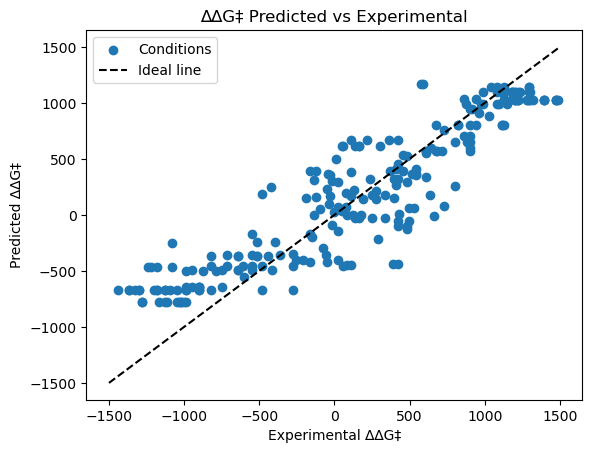

In [10]:
# Visualize predictions
plt.scatter(y_ddg, base_preds)
plt.xlabel("Experimental ∆∆G‡")
plt.ylabel("Predicted ∆∆G‡")
plt.title("∆∆G‡ Predicted vs Experimental")
plt.plot([-1500,1500], [-1500,1500], '--', color = 'black')
plt.legend(['Conditions', 'Ideal line'])
plt.show()

In [11]:
# Error of base model in z%

T_kelvin = T + 273.15
term1 = np.exp(-base_preds/(1.987*T_kelvin))
base_preds_percent = term1/(1+term1)

y_percent_base_error = abs(y - base_preds_percent)
y_percent_base_error = pd.concat([y_percent_base_error, condition_space['ligand_ID']], axis = 1)
y_percent_base_error = y_percent_base_error.rename(columns = {0: "errors"})

grouped_y_percent = y_percent_base_error.groupby(by = 'ligand_ID').mean()
print("MAE in z%")
print("MAE: ", round(grouped_y_percent.mean()*100,2).to_string(index=False), '%')
print("MAE STD: ", round(grouped_y_percent.std()*100,2).to_string(index=False), '%')

MAE in z%
MAE:  8.12 %
MAE STD:  6.72 %


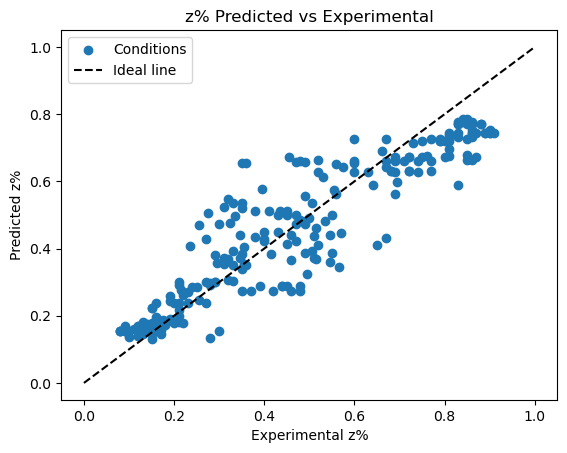

In [12]:
# Visualize predictions
plt.scatter(y, base_preds_percent)
plt.xlabel("Experimental z%")
plt.ylabel("Predicted z%")
plt.title("z% Predicted vs Experimental")
plt.plot([0,1], [0,1], '--', color = 'black')
plt.legend(['Conditions', 'Ideal line'])
plt.show()

Delta Model

In [13]:
# Define input and label
X_delta = processed_train.drop(['z%'], axis = 1)
y_ddg_base_error = y_ddg - base_preds

No feature split, no training set split (nf_nt)

In [14]:
# Forward greedy feature selection: Delta models

# Optional switch to run the following code. Typically this code is expensive
toRun = False


if toRun:
    lolo = LeaveOneGroupOut() # cross validation split

    # Find best fit using same hyperparameters as main model
    indices = list(lolo.split(X_delta, y_ddg_base_error, 
                   groups = condition_space['ligand_ID']))
    kernel = Matern(length_scale = 1.5, nu = 2.5)
    regr = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
                                    n_restarts_optimizer = 5, normalize_y = True)
    sfs = SequentialFeatureSelector(regr, cv = indices, n_features_to_select = 'auto', 
                                    scoring = 'neg_mean_absolute_error', tol = 0.02)

    sfs.fit(X_delta, y_ddg_base_error)
    extracted_features = X_delta.columns[sfs.get_support()]
    print(extracted_features)

In [15]:
# Define features to be used in the delta model, as well as the input and output
feats_delta_nf_nt = ['solvent_dielectric constant', 'reductant_metal',
       'ligand_nbo_bds_e_avg_boltz', 'ligand_E_oxidation_boltz',
       'ligand_pyr_P_delta']

# Uncomment this for more modular flow. Otherwise skip previous cell (expensive)
# feats = extracted_features

X_delta_nf_nt = X_delta[feats_delta_nf_nt]

In [16]:
# Cross-validated estimates for each input data point using LOGO CV
indices = k_folds.split(X_delta_nf_nt, y_ddg_base_error, 
                        groups = condition_space['ligand_ID'])
kernel = Matern(length_scale = 1.5, nu = 2.5)
delta_model_nf_nt = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True)
error_preds_nf_nt = cross_val_predict(delta_model_nf_nt, X_delta_nf_nt, 
              y_ddg_base_error, cv = indices)

r2: 0.02


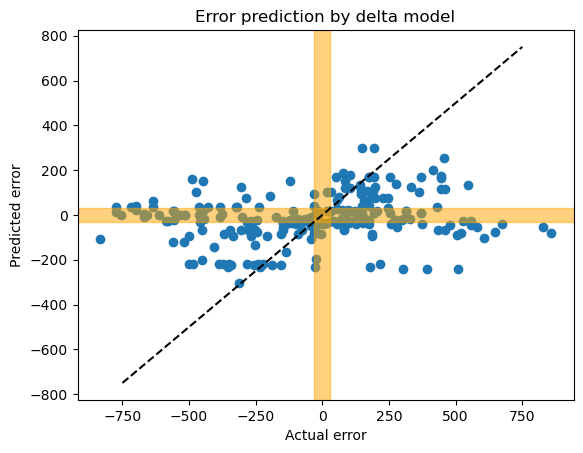

In [17]:
from sklearn.metrics import r2_score
print("r2:", round(r2_score(y_ddg_base_error, error_preds_nf_nt),2))

fig, ax = plt.subplots()
ax.scatter(y_ddg_base_error, error_preds_nf_nt)
plt.xlabel("Actual error")
plt.ylabel("Predicted error")
plt.title("Error prediction by delta model")
plt.plot([-750, 750], [-750, 750], '--', color = 'black')

# Arbitrary threshold to avoid small discrepency along the decision boundary to
# be counted towards the stat (i.e. +1 cal/mol vs -1 cal/mol)
thres = 30
ax.axhspan(-thres, thres, color = 'orange', alpha = 0.5)
ax.axvspan(-thres, thres, color = 'orange', alpha = 0.5)

accurary: 0.66


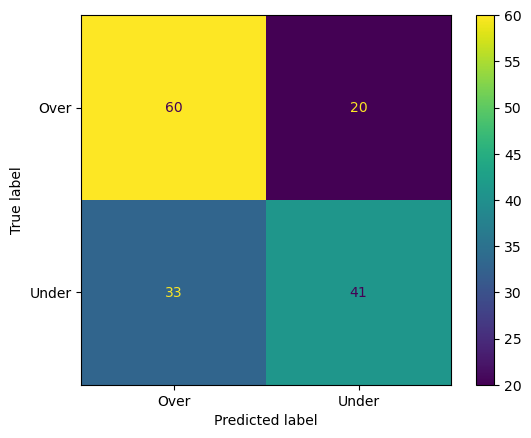

In [18]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

error_anal_nf_nt = pd.DataFrame({"actual": y_ddg_base_error,
                               "predicted": error_preds_nf_nt})
error_anal_nf_nt = error_anal_nf_nt[abs(error_anal_nf_nt['actual']) > 30]
error_anal_nf_nt = error_anal_nf_nt[abs(error_anal_nf_nt['predicted']) > 30]
error_anal_nf_nt = error_anal_nf_nt > 0
confusion_m = confusion_matrix(error_anal_nf_nt['actual'], error_anal_nf_nt['predicted'])
ConfusionMatrixDisplay(confusion_m, display_labels = ['Over', 'Under']).plot()
print("accurary:", round((confusion_m[0][0]+confusion_m[1][1])/np.sum(confusion_m), 2))

In [19]:
# New error with adjusted predictions
errors_nf_nt = abs(y_ddg - (base_preds + error_preds_nf_nt))
errors_nf_nt_df = pd.DataFrame({"errors": errors_nf_nt, 
                  "group":condition_space["ligand_ID"]})
grouped = errors_nf_nt_df.groupby(by = 'group').mean()
print("MAE: ", round(grouped.mean(), 2))
print("MAE STD: ", round(grouped.std()), 2)

MAE:  errors    214.69
dtype: float64
MAE STD:  errors    198.0
dtype: float64 2


In [20]:
# error by groups (PAr3 vs PR3)
errors_nf_nt_df['PAr3'] = is_PAr3_train
part_par3_final = errors_nf_nt_df[errors_nf_nt_df['PAr3'] == 1].drop(['PAr3'], axis = 1)
part_pr3_final = errors_nf_nt_df[errors_nf_nt_df['PAr3'] == 0].drop(['PAr3'], axis = 1)

grouped_par3 = part_par3_final.groupby(by = 'group').mean()
print("PAr3")
print("MAE: ", round(grouped_par3.mean(),2).to_string(index=False))
print("MAE STD: ", round(grouped_par3.std(),2).to_string(index=False))

grouped_pr3 = part_pr3_final.groupby(by = 'group').mean()
print("\nPR3")
print("MAE: ", round(grouped_pr3.mean(),2).to_string(index=False))
print("MAE STD: ", round(grouped_pr3.std(),2).to_string(index=False))

PAr3
MAE:  122.81
MAE STD:  97.39

PR3
MAE:  257.82
MAE STD:  218.33


Text(0, 0.5, 'Predicted')

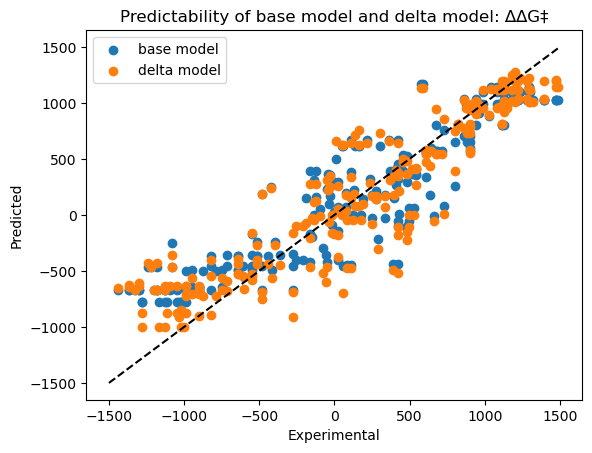

In [21]:
# Plot both base and adjusted model
adjusted = base_preds + error_preds_nf_nt
plt.scatter(y_ddg, base_preds)
plt.scatter(y_ddg, adjusted)
plt.plot([-1500,1500], [-1500,1500], '--', color = 'black')
plt.legend(["base model", "delta model"])
plt.title("Predictability of base model and delta model: ∆∆G‡")
plt.xlabel("Experimental")
plt.ylabel("Predicted")

In [22]:
# Error of nf_nt delta model in z%

T_kelvin = T + 273.15
term1 = np.exp(-adjusted/(1.987*T_kelvin))
nf_nt_preds_percent = term1/(1+term1)

y_percent_nf_nt_error = abs(y - nf_nt_preds_percent)
y_percent_nf_nt_error = pd.concat([y_percent_nf_nt_error, condition_space['ligand_ID']], axis = 1)
y_percent_nf_nt_error = y_percent_nf_nt_error.rename(columns = {0: "errors"})

grouped_y_percent_nf_nt = y_percent_nf_nt_error.groupby(by = 'ligand_ID').mean()
print("MAE in z%")
print("MAE: ", round(grouped_y_percent_nf_nt.mean()*100,2).to_string(index=False), '%')
print("MAE STD: ", round(grouped_y_percent_nf_nt.std()*100,2).to_string(index=False), '%')

MAE in z%
MAE:  7.31 %
MAE STD:  6.93 %


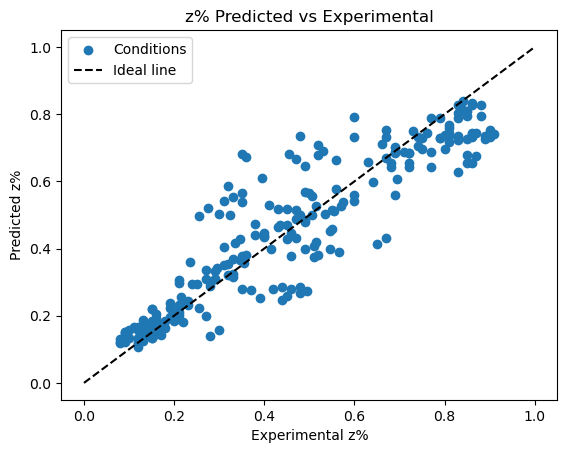

In [23]:
# Visualize predictions
plt.scatter(y, nf_nt_preds_percent)
plt.xlabel("Experimental z%")
plt.ylabel("Predicted z%")
plt.title("z% Predicted vs Experimental")
plt.plot([0,1], [0,1], '--', color = 'black')
plt.legend(['Conditions', 'Ideal line'])
plt.show()

Feature split, training set split (f_t)

In [24]:
# Combine relevant data into one to avoid possibility of data leakage
combined = pd.concat([processed_train, 
           pd.DataFrame(base_preds, index = processed_train.index, columns = ['base_preds']),
           pd.DataFrame(y_ddg, index = processed_train.index, columns = ['y_ddg']), 
           condition_space['ligand_ID'].to_frame()],
           axis = 1)

# Import structural data, add them into combined df
is_PAr3_df = pd.read_csv(s3+"datasets/is_PAr3_all_ligands.csv", index_col = 0).dropna()
combined['PAr3'] = combined['ligand_ID'].map(lambda x: int(is_PAr3_df['PAr3'][x]))
part_par3 = combined[combined['PAr3'] == 1]
part_pr3 = combined[combined['PAr3'] == 0]

# Sanity check: Check no overlapping datapoints between the two partitions
assert(len(set(part_par3.index).intersection(set(part_pr3.index))) == 0)


Delta model for Triaryl monophosphine partition (PAr3)

In [25]:
# Define input and label
X_par3 = part_par3.drop(['z%', 'base_preds', 'y_ddg', 'ligand_ID', 'PAr3'], axis = 1)
y_ddg_base_error_par3 = part_par3['y_ddg'] - part_par3['base_preds']

In [26]:
# Forward greedy feature selection: Delta models - PAr3 partition

# Optional switch to run the following code. Typically this code is expensive
toRun = False


if toRun:
    lolo = LeaveOneGroupOut() # cross validation split
    
    # Find best fit using same hyperparameters as main model
    indices = list(lolo.split(X_par3, y_ddg_base_error_par3, 
                   groups = part_par3['ligand_ID']))
    kernel = Matern(length_scale = 1.5, nu = 2.5)
    regr = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
                                    n_restarts_optimizer = 5, normalize_y = True)
    sfs = SequentialFeatureSelector(regr, cv = indices, n_features_to_select = 'auto', 
                                    scoring = 'neg_mean_absolute_error', tol = 0.01)

    sfs.fit(X_par3, y_ddg_base_error_par3)
    extracted_features = X_par3.columns[sfs.get_support()]
    print(extracted_features)

In [27]:
# Define features to be used in the delta model, as well as the input and output
feats_delta_par3 = ['reductant_n_carbons', 'reductant_metal',
       'ligand_nbo_lp_P_percent_s_boltz', 'ligand_nbo_bd_e_avg_boltz',
       'ligand_vbur_ovbur_min_vburminconf']

# Uncomment this for more modular flow. Otherwise skip previous cell (expensive)
# feats = extracted_features

X_delta_par3 = X_par3[feats_delta_par3]

Delta model for Non-Triaryl monophosphine partition (PR3)

In [28]:
# Define input and label
X_pr3 = part_pr3.drop(['z%', 'base_preds', 'y_ddg', 'ligand_ID', 'PAr3'], axis = 1)
y_ddg_base_error_pr3 = part_pr3['y_ddg'] - part_pr3['base_preds']

In [29]:
# Not split features, not split training set
# Cross-validated estimates for each input data point using LOGO CV
indices = k_folds.split(X_delta_par3, y_ddg_base_error_par3, 
                        groups = part_par3['ligand_ID'])
kernel = Matern(length_scale = 1.5, nu = 2.5)
delta_model_par3 = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True)
error_preds_par3 = cross_val_predict(delta_model_par3, X_delta_par3, 
              y_ddg_base_error_par3, cv = indices)

In [30]:
# Forward greedy feature selection: Delta models - PR3 partition

# Optional switch to run the following code. Typically this code is expensive
toRun = False



if toRun:
    X_pr3 = part_pr3.drop(['z%', 'base_preds', 'y_ddg', 'ligand_ID', 'PAr3'], axis = 1)
    y_ddg_base_error_pr3 = part_pr3['y_ddg'] - part_pr3['base_preds']
    lolo = LeaveOneGroupOut() # cross validation split
    
    # Find best fit using same hyperparameters as main model
    indices = list(lolo.split(X_pr3, y_ddg_base_error_pr3, 
                   groups = part_pr3['ligand_ID']))
    kernel = Matern(length_scale = 1.5, nu = 2.5)
    regr = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
                                    n_restarts_optimizer = 5, normalize_y = True)
    sfs = SequentialFeatureSelector(regr, cv = indices, n_features_to_select = 'auto', 
                                    scoring = 'neg_mean_absolute_error', tol = 0.02)

    sfs.fit(X_pr3, y_ddg_base_error_pr3)
    extracted_features = X_pr3.columns[sfs.get_support()]
    print(extracted_features)

In [31]:
# Define features to be used in the delta model, as well as the input and output
feats_delta_pr3 =  ['ligand_E_solv_cds_boltz','ligand_qpole_amp_boltz','reductant_n_beta_H']

# Uncomment this for more modular flow. Otherwise skip previous cell (expensive)
# feats = extracted_features

X_delta_pr3 = X_pr3[feats_delta_pr3]

In [32]:
# Not split features, not split training set
# Cross-validated estimates for each input data point using LOGO CV
indices = k_folds.split(X_delta_pr3, y_ddg_base_error_pr3, 
                        groups = part_pr3['ligand_ID'])
kernel = Matern(length_scale = 1.5, nu = 2.5)
delta_model_pr3 = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True)
error_preds_pr3 = cross_val_predict(delta_model_pr3, X_delta_pr3, 
              y_ddg_base_error_pr3, cv = indices)

Combine both delta models

In [33]:
# Combine predictions from both par3 and pr3 partitions
error_preds_f_t = pd.concat(
    [pd.DataFrame(error_preds_par3, index = part_par3.index, columns = ['preds_f_t']),
     pd.DataFrame(error_preds_pr3, index = part_pr3.index, columns = ['preds_f_t'])])
error_preds_f_t = error_preds_f_t.reindex(processed_train.index).squeeze()

r2: -0.01


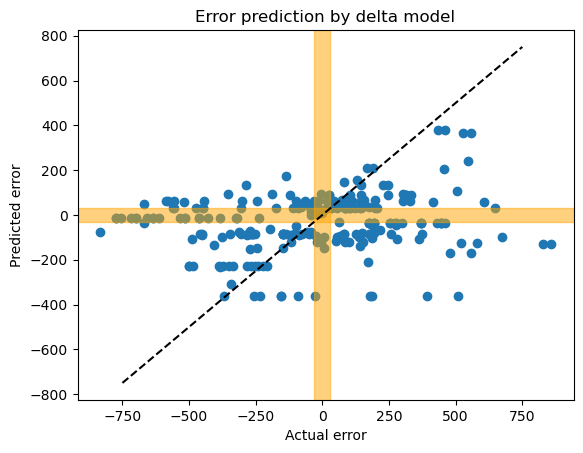

In [34]:
from sklearn.metrics import r2_score
print("r2:", round(r2_score(y_ddg_base_error, error_preds_f_t),2))
fig, ax = plt.subplots()
ax.scatter(y_ddg_base_error, error_preds_f_t)
plt.xlabel("Actual error")
plt.ylabel("Predicted error")
plt.title("Error prediction by delta model")
plt.plot([-750, 750], [-750, 750], '--', color = 'black')

thres = 30
ax.axhspan(-thres, thres, color = 'orange', alpha = 0.5)
ax.axvspan(-thres, thres, color = 'orange', alpha = 0.5)

accurary: 0.59


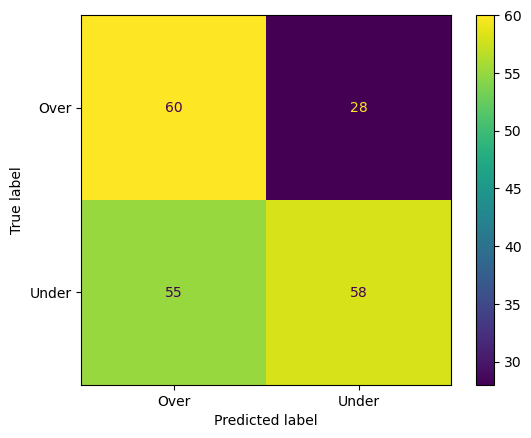

In [35]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

error_anal_f_t = pd.DataFrame({"actual": y_ddg_base_error,
                               "predicted": error_preds_f_t})
error_anal_f_t = error_anal_f_t[abs(error_anal_f_t['actual']) > 30]
error_anal_f_t = error_anal_f_t[abs(error_anal_f_t['predicted']) > 30]
error_anal_f_t = error_anal_f_t > 0
confusion_m = confusion_matrix(error_anal_f_t['actual'], error_anal_f_t['predicted'])
ConfusionMatrixDisplay(confusion_m, display_labels = ['Over', 'Under']).plot()
print("accurary:", round((confusion_m[0][0]+confusion_m[1][1])/np.sum(confusion_m), 2))

In [36]:
# New error with adjusted predictions
errors_f_t = abs(y_ddg - (base_preds + error_preds_f_t))
errors_f_t_df = pd.DataFrame({"errors": errors_f_t, 
                  "group":condition_space["ligand_ID"]})
grouped = errors_f_t_df.groupby(by = 'group').mean()
print("MAE: ", round(grouped.mean(), 2))
print("MAE STD: ", round(grouped.std()), 2)

MAE:  errors    208.76
dtype: float64
MAE STD:  errors    189.0
dtype: float64 2


In [37]:
# error by groups (PAr3 vs PR3)
errors_f_t_df['PAr3'] = combined['PAr3']
part_par3_final = errors_f_t_df[errors_f_t_df['PAr3'] == 1].drop(['PAr3'], axis = 1)
part_pr3_final = errors_f_t_df[errors_f_t_df['PAr3'] == 0].drop(['PAr3'], axis = 1)

grouped_par3 = part_par3_final.groupby(by = 'group').mean()
print("PAr3")
print("MAE: ", round(grouped_par3.mean(),2).to_string(index=False))
print("MAE STD: ", round(grouped_par3.std(),2).to_string(index=False))

grouped_pr3 = part_pr3_final.groupby(by = 'group').mean()
print("\nPR3")
print("MAE: ", round(grouped_pr3.mean(),2).to_string(index=False))
print("MAE STD: ", round(grouped_pr3.std(),2).to_string(index=False))

PAr3
MAE:  124.45
MAE STD:  129.91

PR3
MAE:  248.34
MAE STD:  200.28


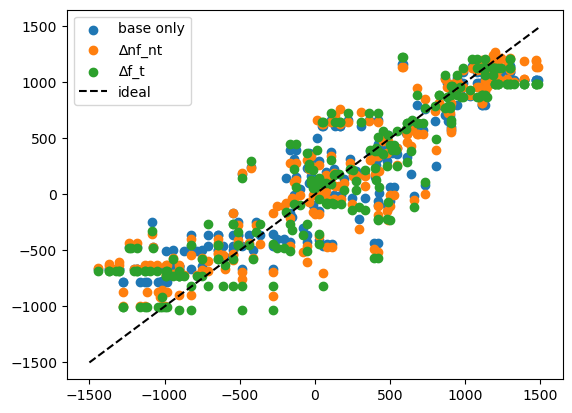

In [38]:
plt.scatter(y_ddg, base_preds)
plt.scatter(y_ddg, base_preds + error_preds_nf_nt)
plt.scatter(y_ddg, base_preds + error_preds_f_t)
# plt.scatter(part_par3['y_ddg'], error_preds_par3)
plt.plot([-1500, 1500], [-1500, 1500], '--', color = 'black',)
plt.legend(['base only', '∆nf_nt', '∆f_t', 'ideal'])

In [39]:
# Error of f_t delta model in z%
adjusted_preds_f_t = base_preds + error_preds_f_t

T_kelvin = T + 273.15
term1 = np.exp(-adjusted_preds_f_t/(1.987*T_kelvin))
f_t_preds_percent = term1/(1+term1)

y_percent_f_t_error = abs(y - f_t_preds_percent)
y_percent_f_t_error = pd.concat([y_percent_f_t_error, condition_space['ligand_ID']], axis = 1)
y_percent_f_t_error = y_percent_f_t_error.rename(columns = {0: "errors"})

grouped_y_percent_f_t = y_percent_f_t_error.groupby(by = 'ligand_ID').mean()
print("MAE in z%")
print("MAE: ", round(grouped_y_percent_f_t.mean()*100,2).to_string(index=False), '%')
print("MAE STD: ", round(grouped_y_percent_f_t.std()*100,2).to_string(index=False), '%')

MAE in z%
MAE:  7.09 %
MAE STD:  6.62 %


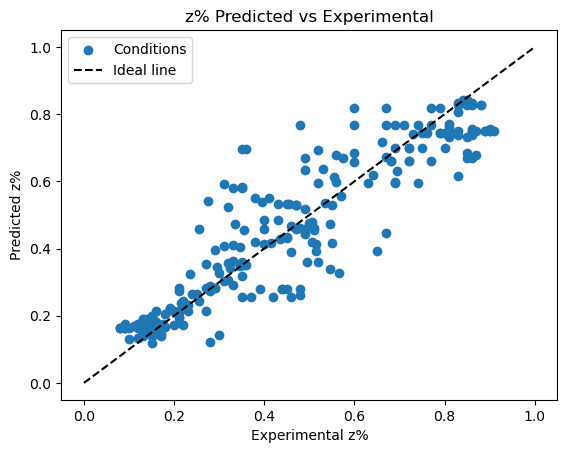

In [40]:
# Visualize predictions
plt.scatter(y, f_t_preds_percent)
plt.xlabel("Experimental z%")
plt.ylabel("Predicted z%")
plt.title("z% Predicted vs Experimental")
plt.plot([0,1], [0,1], '--', color = 'black')
plt.legend(['Conditions', 'Ideal line'])
plt.show()

Predict

In [41]:
test_set = pd.read_csv(s3+"datasets/test_set.csv", index_col = 0)
test_set

,reductant_metal,ligand_vbur_far_vbur_boltz,ligand_nbo_lp_P_percent_s_boltz,ligand_nmrtens_szz_P_boltz,reductant_n_beta_H,ligand_vbur_far_vbur_min,ligand_efg_amp_P_boltz,reductant_n_carbons,ligand_pyr_P_delta,ligand_E_solv_total_boltz,...,ligand_pyr_P_boltz,ligand_sterimol_B1_boltz,ligand_nbo_bds_occ_avg_boltz,ligand_nbo_bd_occ_avg_boltz,ligand_qpole_amp_boltz,ligand_efgtens_xx_P_boltz,ligand_vbur_ovbur_min_vburminconf,ligand_nbo_lp_P_occ_boltz,ligand_sterimol_B1_min,ligand_E_solv_cds_boltz
3069326,1,4.116689,50.565269,343.627693,2,0.0,1.747407,4,0.067717,-12.925720,...,0.926201,4.394997,0.034993,1.954971,4.057338,-0.803842,0.0,1.933998,3.465580,-8.392010
3098928,1,4.116689,50.565269,343.627693,2,0.0,1.747407,4,0.067717,-12.925720,...,0.926201,4.394997,0.034993,1.954971,4.057338,-0.803842,0.0,1.933998,3.465580,-8.392010
3111392,1,4.116689,50.565269,343.627693,2,0.0,1.747407,4,0.067717,-12.925720,...,0.926201,4.394997,0.034993,1.954971,4.057338,-0.803842,0.0,1.933998,3.465580,-8.392010
124706,1,4.116689,50.565269,343.627693,2,0.0,1.747407,3,0.067717,-12.925720,...,0.926201,4.394997,0.034993,1.954971,4.057338,-0.803842,0.0,1.933998,3.465580,-8.392010
1600132,0,4.116689,50.565269,343.627693,2,0.0,1.747407,3,0.067717,-12.925720,...,0.926201,4.394997,0.034993,1.954971,4.057338,-0.803842,0.0,1.933998,3.465580,-8.392010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555249,0,0.000000,49.375159,360.397032,2,0.0,1.811709,3,0.006759,-13.059046,...,0.934315,4.140553,0.039069,1.955161,5.631674,-0.817920,0.0,1.894899,4.092583,-6.405159
15945,1,0.000000,49.375159,360.397032,2,0.0,1.811709,3,0.006759,-13.059046,...,0.934315,4.140553,0.039069,1.955161,5.631674,-0.817920,0.0,1.894899,4.092583,-6.405159
56453,1,0.000000,49.375159,360.397032,2,0.0,1.811709,3,0.006759,-13.059046,...,0.934315,4.140553,0.039069,1.955161,5.631674,-0.817920,0.0,1.894899,4.092583,-6.405159
3047813,1,0.000000,49.375159,360.397032,2,0.0,1.811709,4,0.006759,-13.059046,...,0.934315,4.140553,0.039069,1.955161,5.631674,-0.817920,0.0,1.894899,4.092583,-6.405159


In [42]:
# Normalize test set based on scaling factors of train set
from sklearn.preprocessing import StandardScaler
OHE_cols = ['reductant_metal']
OHE = test_set[OHE_cols]
nonOHE = test_set.drop(OHE_cols, axis = 1)
scaler = StandardScaler()
scaler.fit(unprocessed_train[nonOHE.columns])
test_set = pd.DataFrame(scaler.transform(test_set.drop(OHE_cols, axis = 1)), 
                    index = test_set.index, columns = nonOHE.columns)
for col in OHE_cols:
    test_set[col] = OHE[col]
test_set

,ligand_vbur_far_vbur_boltz,ligand_nbo_lp_P_percent_s_boltz,ligand_nmrtens_szz_P_boltz,reductant_n_beta_H,ligand_vbur_far_vbur_min,ligand_efg_amp_P_boltz,reductant_n_carbons,ligand_pyr_P_delta,ligand_E_solv_total_boltz,ligand_nbo_bd_e_avg_boltz,...,ligand_sterimol_B1_boltz,ligand_nbo_bds_occ_avg_boltz,ligand_nbo_bd_occ_avg_boltz,ligand_qpole_amp_boltz,ligand_efgtens_xx_P_boltz,ligand_vbur_ovbur_min_vburminconf,ligand_nbo_lp_P_occ_boltz,ligand_sterimol_B1_min,ligand_E_solv_cds_boltz,reductant_metal
3069326,-0.152854,-0.104010,0.584716,-0.446726,-0.152741,-0.314537,0.718345,0.734265,0.463973,0.556079,...,-0.101547,-0.347637,0.060089,-0.985967,-0.321327,-0.064416,0.651597,-0.930702,-0.372972,1
3098928,-0.152854,-0.104010,0.584716,-0.446726,-0.152741,-0.314537,0.718345,0.734265,0.463973,0.556079,...,-0.101547,-0.347637,0.060089,-0.985967,-0.321327,-0.064416,0.651597,-0.930702,-0.372972,1
3111392,-0.152854,-0.104010,0.584716,-0.446726,-0.152741,-0.314537,0.718345,0.734265,0.463973,0.556079,...,-0.101547,-0.347637,0.060089,-0.985967,-0.321327,-0.064416,0.651597,-0.930702,-0.372972,1
124706,-0.152854,-0.104010,0.584716,-0.446726,-0.152741,-0.314537,-1.150897,0.734265,0.463973,0.556079,...,-0.101547,-0.347637,0.060089,-0.985967,-0.321327,-0.064416,0.651597,-0.930702,-0.372972,1
1600132,-0.152854,-0.104010,0.584716,-0.446726,-0.152741,-0.314537,-1.150897,0.734265,0.463973,0.556079,...,-0.101547,-0.347637,0.060089,-0.985967,-0.321327,-0.064416,0.651597,-0.930702,-0.372972,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555249,-0.541940,-0.501299,1.219201,-0.446726,-0.152741,0.347378,-1.150897,-0.925989,0.421467,-0.387916,...,-0.648679,0.028048,0.100637,-0.613600,-0.500185,-0.064416,-1.342727,0.072245,0.371215,0
15945,-0.541940,-0.501299,1.219201,-0.446726,-0.152741,0.347378,-1.150897,-0.925989,0.421467,-0.387916,...,-0.648679,0.028048,0.100637,-0.613600,-0.500185,-0.064416,-1.342727,0.072245,0.371215,1
56453,-0.541940,-0.501299,1.219201,-0.446726,-0.152741,0.347378,-1.150897,-0.925989,0.421467,-0.387916,...,-0.648679,0.028048,0.100637,-0.613600,-0.500185,-0.064416,-1.342727,0.072245,0.371215,1
3047813,-0.541940,-0.501299,1.219201,-0.446726,-0.152741,0.347378,0.718345,-0.925989,0.421467,-0.387916,...,-0.648679,0.028048,0.100637,-0.613600,-0.500185,-0.064416,-1.342727,0.072245,0.371215,1


In [43]:
# Base model trained on whole training set

# Base Model
from sklearn.model_selection import cross_validate, cross_val_predict

base_test_x = processed_train[feats]
base_test_y = y_ddg

kernel = Matern(length_scale = 1.5, nu = 2.5)
base_model = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True).fit(base_test_x, base_test_y)
print("Score:", round(base_model.score(base_test_x, base_test_y),2))
                
base_model_whole_preds = base_model.predict(base_test_x)

Score: 0.94


Make base model predictions on test set

In [44]:
# Split into partition size suitable for local computer's RAM capacity.
# Adjust according to RAM. Maximum size is 5860800
partition_size = 3000000
first_half_base = base_model.predict(test_set[feats][:partition_size])
second_half_base = base_model.predict(test_set[feats][partition_size:])
kraken_base_preds = np.concatenate([first_half_base, second_half_base])

Make delta model predictions on test set

In [45]:
# Add one hot encoded PAr3 identifier to split the test set into PAr3 and PR3 partitions
kraken_pre_feats = pd.read_csv(s3+"datasets/test_set_raw.csv", index_col = 0)
PAr3_test_set = kraken_pre_feats['ligands'].map(lambda x: is_PAr3_df['PAr3'][x])
test_set['PAr3'] = PAr3_test_set

In [46]:
# Delta model predictions PR3
test_set_delta_pr3 = test_set[test_set['PAr3'] == 0]

kernel = Matern(length_scale = 1.5, nu = 2.5)
delta_model_pr3 = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True).fit(X_delta_pr3, y_ddg_base_error_pr3)
print("Score:", round(delta_model_pr3.score(X_delta_pr3, y_ddg_base_error_pr3), 2))
                
delta_model_pr3_whole_preds = delta_model_pr3.predict(X_delta_pr3)

Score: 0.81


In [47]:
delta_pr3_test_set_preds_first_half = delta_model_pr3.predict(test_set_delta_pr3[feats_delta_pr3])[:partition_size]
delta_pr3_test_set_preds_second_half = delta_model_pr3.predict(test_set_delta_pr3[feats_delta_pr3])[partition_size:]

delta_pr3_test_set_preds = np.concatenate([delta_pr3_test_set_preds_first_half, delta_pr3_test_set_preds_second_half])
delta_pr3_test_set_preds = pd.DataFrame(delta_pr3_test_set_preds, index = test_set_delta_pr3.index, columns = ['delta_preds'])
delta_pr3_test_set_preds

,delta_preds
3069326,-539.928856
3098928,-539.928856
3111392,-539.928856
124706,-539.928856
1600132,-539.928856
...,...
1555249,-15.489065
15945,-15.489065
56453,-15.489065
3047813,-15.489065


In [48]:
# Delta model predictions par3
test_set_delta_par3 = test_set[test_set['PAr3'] == 1]

kernel = Matern(length_scale = 1.5, nu = 2.5)
delta_model_par3 = GaussianProcessRegressor(kernel = kernel, alpha = 0.5, 
              n_restarts_optimizer = 25, normalize_y = True).fit(X_delta_par3, y_ddg_base_error_par3)
print("Score:", round(delta_model_par3.score(X_delta_par3, y_ddg_base_error_par3), 2))
                
delta_model_par3_whole_preds = delta_model_par3.predict(X_delta_par3)

Score: 0.57


In [49]:
delta_par3_test_set_preds = delta_model_par3.predict(test_set_delta_par3[feats_delta_par3])
delta_par3_test_set_preds = pd.DataFrame(delta_par3_test_set_preds, index = test_set_delta_par3.index, columns = ['delta_preds'])
delta_par3_test_set_preds

,delta_preds
6025228,35.254928
6051714,35.254928
6017438,35.254928
6023670,35.254928
5984720,35.254928
...,...
3064714,286.722714
45310,122.087828
3042902,286.722714
46868,122.087828


In [50]:
# Combine all predictions
base_test_preds_all = pd.DataFrame(kraken_base_preds, index = test_set.index, columns = ['base_preds'])
delta_test_preds_all = pd.concat([delta_pr3_test_set_preds, delta_par3_test_set_preds]).reindex(test_set.index)
final_preds = base_test_preds_all['base_preds'] + delta_test_preds_all['delta_preds']
final_preds = pd.DataFrame(final_preds, index = base_test_preds_all.index, columns = ['final_preds'])

condition_cols = ['reductant', 'reductant_C', 'temperature', 'catalyst_C', 'cat2lig',
       'solvent', 'concentration', 'ligands']
final_preds_with_conditions = pd.concat([kraken_pre_feats[condition_cols], final_preds], axis = 1)

In [51]:
# Convert predicted ∆∆G‡ to z%
T_test = final_preds_with_conditions['temperature'] + 273.15
ddg_test = final_preds_with_conditions['final_preds']
R_test = 1.987# R is constant but named with _test for avoid any other variable collisions
val = np.exp(-ddg_test/(R_test*T_test))
z_test = val/(1+val)
final_preds_with_conditions['final_preds_z'] = z_test

# Add smiles string of the ligand
id_to_smiles = pd.read_csv(s3+"datasets/kraken_structural_OHE.csv", index_col = 1)['CAN SMILES']
smiles = final_preds_with_conditions['ligands'].map(lambda x: id_to_smiles.loc[x])
final_preds_with_conditions['smiles'] = smiles

In [52]:
# Extract condition with highest predicted selectivity for each ligand

top_zs = final_preds_with_conditions.groupby('ligands').max().sort_values(by = 'final_preds_z', ascending = False)

top_es = final_preds_with_conditions.groupby('ligands').min().sort_values(by = 'final_preds_z', ascending = True)



In [53]:
# Uncomment code to download top z and e selective ligand space to local machine

# from pathlib import Path


# Path('datasets').mkdir(exist_ok = True)
# top_zs.to_csv("datasets/top_z_predicted.csv")
# top_es.to_csv("datasets/top_e_predicted.csv")

In [54]:
# Observe top predictions
top_zs.head(20)

,reductant,reductant_C,temperature,catalyst_C,cat2lig,solvent,concentration,final_preds,final_preds_z,smiles
ligands,,,,,,,,,,
67,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,58.530739,0.935311,Cc1ccccc1P(C1CCCCC1)C1CCCCC1
44,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-261.012337,0.907464,c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1
736,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-430.433800,0.884184,COc1cc(OC)c(P(C2CCCCC2)C2CCCCC2)c(OC)c1
287,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-269.515413,0.882223,c1ccc(P(C2CCCCC2)C2CCCCC2)c(C2OCCO2)c1
68,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-47.133605,0.857129,c1ccc(P(C2CCCCC2)C2CCCCC2)cc1
715,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-243.532876,0.851531,c1ccc(C2=C(P(C3CCCCC3)C3CCCCC3)C3c4ccccc4C2c2c...
314,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-306.589680,0.850958,c1ccc(-n2c(P(C3CCCCC3)C3CCCCC3)cc3ccccc32)cc1
301,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-169.647054,0.845906,Brc1ccccc1P(C1CCCCC1)C1CCCCC1
1147,sec-BuZnBr,3.0,70.0,10.0,3.0,dibutyl ether,0.2,-277.439252,0.845396,C(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1


In [55]:
# Observe top predictions
top_es.head(20)

,reductant,reductant_C,temperature,catalyst_C,cat2lig,solvent,concentration,final_preds,final_preds_z,smiles
ligands,,,,,,,,,,
133,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,738.111131,0.078198,Fc1cccc(P(c2cccc(F)c2)c2cccc(F)c2)c1
233,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,662.674845,0.095283,Clc1cccc(P(c2cccc(Cl)c2)c2cccc(Cl)c2)c1
764,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,725.934365,0.102514,FC(F)(F)c1cccc(P(c2ccccc2)c2cccc(C(F)(F)F)c2)c1
768,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,578.519613,0.104709,FC(F)(F)c1ccc(P(c2ccccc2)c2ccc(C(F)(F)F)cc2)cc1
230,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,605.228842,0.106501,Fc1ccc(P(c2cccc(F)c2)c2cccc(F)c2)cc1
1262,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,555.632052,0.116616,FC(F)(F)Oc1ccc(P(c2ccc(OC(F)(F)F)cc2)c2ccc(OC(...
758,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,602.873688,0.124952,Fc1cc(F)cc(P(c2ccccc2)c2cc(F)cc(F)c2)c1
126,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,465.278589,0.125598,Clc1ccc(P(c2ccc(Cl)cc2)c2ccc(Cl)cc2)cc1
777,i-PrMgCl_LiCl,2.0,30.0,5.0,2.0,CPME,0.05,485.596104,0.125795,COc1ccc(P(c2ccc(C(F)(F)F)cc2)c2ccc(C(F)(F)F)cc...
